In [14]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage,HumanMessage
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator
load_dotenv()

True

In [15]:
class strucuted_Schema_For_Tweet_Evolution(BaseModel):
    evolution:Literal['approved','need_improvement']=Field(description='Final Evolution wheather approved or need improvement')
    feedback:str=Field(description='feedback for the tweet')

In [16]:
generator_llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
evaluator_llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash")
strucutred_evalautor_llm=evaluator_llm.with_structured_output(strucuted_Schema_For_Tweet_Evolution)
optimizer_llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash")

E0000 00:00:1760459999.537426   30266 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1760459999.540032   30266 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1760459999.543199   30266 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [17]:
class TweetState(TypedDict):
    topic:str 
    tweet:str
    evalution:Literal['approved','needs_improvement']
    feedback:str
    iteration:int
    max_iteration:int
    tweet_hsitory:Annotated[list[str],operator.add]
    feedback_hsitory:Annotated[list[str],operator.add]

In [18]:
def generate_tweet(state:TweetState):
    topic=state['topic']
    messages = [
SystemMessage(content="You are funny and clever Twitter/X influencer."),
HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: {topic}.
Rules:
Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
- This is version {state['iteration']+1}
""")
]
    response=generator_llm.invoke(messages).content
    return {
        'tweet':response,
        'tweet_hsitory':[response]
    }

In [19]:
def evaulate_tweet(state:TweetState):
    messages = [
SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor,originality, virality, and tweet format."),
HumanMessage(content=f"""
Evaluate the following tweet:
             
Tweet: "{state['tweet']}"
             
Use the criteria below to evaluate the tweet:

1. Originality - Is this fresh, or have you seen it a hundred times before?
2. Humor - Did it genuinely make you smile, laugh, or chuckle?
3. Punchiness - Is it short, sharp, and scroll-stopping?
4. Virality Potential - Would people retweet or share it?
5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 400 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "why |did..." or "what happens when...")
- It exceeds 400 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"
feedback: One paragraph explaining the strengths and weaknesses

""")
    ]
    response=strucutred_evalautor_llm.invoke(messages)
    return {
        'evalution':response.evolution,"feedback":response.feedback , "feedback_hsitory":[response.feedback]
    }


In [20]:
def optimize_tweet(state:TweetState):
    messages = [
SystemMessage(content= "You punch up tweets for virality and humor based on given feedback."),
HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state["feedback"]}"
Topic: "{state["topic"]}"
Original Tweet:
"{state["tweet"]}"
Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")]
    response=optimizer_llm.invoke(messages).content
    iteration=state['iteration']+1
    return {
         'tweet':response,
         'tweet_hsitory':[response],
         'iteration':iteration
    }

In [21]:
def handle_evolution(state:TweetState)->Literal['optmize','END']:
    if state['evalution']=='approved' or state['iteration']>state['max_iteration']:
        return 'approved'
    return 'needs_improvement'

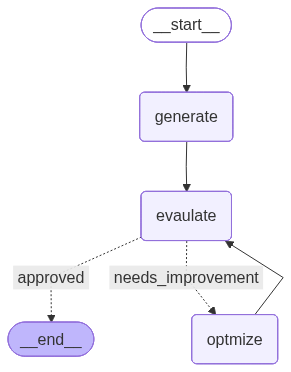

In [22]:
graph=StateGraph(TweetState)

graph.add_node('generate',generate_tweet)
graph.add_node('evaulate',evaulate_tweet)
graph.add_node('optmize',optimize_tweet)


graph.add_edge(START,'generate')
graph.add_edge('generate','evaulate')
graph.add_conditional_edges('evaulate',handle_evolution,{'approved':END,'needs_improvement':'optmize'})
graph.add_edge('optmize','evaulate')

workflow=graph.compile()
workflow



In [27]:
intial_state={
    'topic':'Egdbeq',
    'iteration':1,
    'max_iteration':5
}
final_state=workflow.invoke(intial_state)


In [28]:
final_state

{'topic': 'Egdbeq',
 'tweet': "Just tried to spell 'Egdbeq'. My brain immediately went on strike, demanding hazard pay and a new dictionary. This isn't a word, it's a neurological challenge. 🤯 #Egdbeq #BrainMelt",
 'evalution': 'approved',
 'feedback': "This tweet demonstrates strong humor and originality, particularly with the clever imagery of a brain going on strike and demanding hazard pay for a 'neurological challenge.' The made-up word 'Egdbeq' serves as an excellent focal point, making the scenario highly relatable to anyone who's struggled with spelling. Its concise format, effective use of emojis, and relevant hashtags contribute to its punchiness and high virality potential, making it a well-crafted and engaging piece of content that would likely resonate with a broad audience on Twitter.",
 'iteration': 2,
 'max_iteration': 5,
 'tweet_hsitory': ['My brain trying to remember the password I set 3 years ago vs. my brain trying to spell "Egdbeq":\n\nBrain: "Egdbeq? Is that a new